# BoolForge Tutorial 5: Example Use Cases of the Random Function Generator

In this tutorial, we explore example use cases of BoolForge’s random Boolean
function generator. This functionality allows generating large ensembles of
Boolean functions with prescribed structural properties and studying their
statistical and dynamical characteristics.

## What you will learn
In this tutorial you will learn how to:

- compute the prevalence of canalization, $k$-canalization, and nested canalization,
- determine distributions of canalizing strength and normalized input redundancy,
- investigate correlations between absolute bias and canalization,
- generate and analyze dynamically distinct nested canalizing functions.

It is strongly recommended to complete the previous tutorials first.

---
## 0. Setup

In [1]:
import boolforge
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

---
## 1. Prevalence of canalization

Using random sampling, we estimate how frequently Boolean functions of degree $n$
exhibit a given canalizing depth.

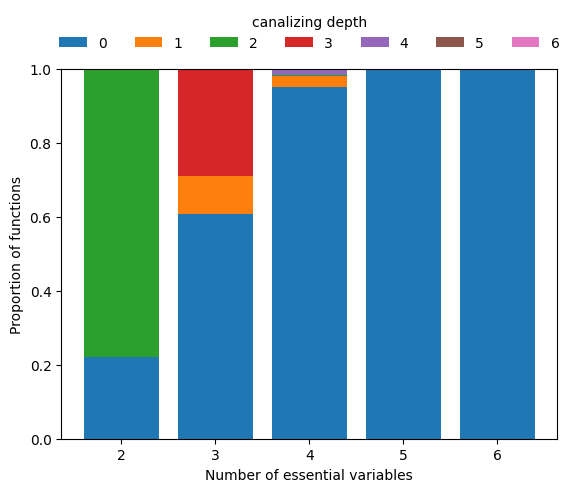

,k=0,k=1,k=2,k=3,k=4,k=5,k=6
n=2,0.221,0.000,0.779,0.000,0.000,0.0,0.0
n=3,0.608,0.103,0.000,0.289,0.000,0.0,0.0
n=4,0.952,0.030,0.003,0.000,0.015,0.0,0.0
n=5,1.000,0.000,0.000,0.000,0.000,0.0,0.0
n=6,1.000,0.000,0.000,0.000,0.000,0.0,0.0


In [2]:
nsim = 1000
ns = np.arange(2, 7)
canalizing_depths = np.arange(max(ns) + 1)

count_depths = np.zeros((len(ns), max(ns) + 1))

for _ in range(nsim):
    for i, n in enumerate(ns):
        f = boolforge.random_function(n)
        count_depths[i, f.get_canalizing_depth()] += 1

count_depths /= nsim

fig, ax = plt.subplots()
for i, depth in enumerate(canalizing_depths):
    ax.bar(
        ns,
        count_depths[:, i],
        bottom=np.sum(count_depths[:, :i], axis=1),
        label=str(depth),
    )

ax.legend(
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=8,
    title="canalizing depth",
)
ax.set_xticks(ns)
ax.set_xlabel("Number of essential variables")
ax.set_ylabel("Proportion of functions")
plt.show()

pd.DataFrame(
    count_depths,
    index=["n=" + str(n) for n in ns],
    columns=["k=" + str(k) for k in canalizing_depths],
)

We see that hardly any Boolean function with $n\geq 5$ inputs is canalizing, let alone nested canalizing. 
This makes the finding that most Boolean functions in published Boolean gene regulatory network models
are nested canalizing very surprising (Kadelka et al., Science Advances, 2024).

To zoom in on the few functions that are canalizing for higher $n$, we can simply require `depth=1` and repeat the above analysis.

### Restricting to canalizing functions

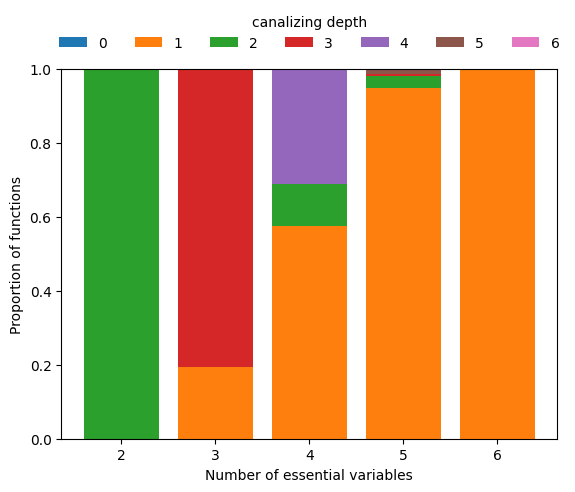

,k=0,k=1,k=2,k=3,k=4,k=5,k=6
n=2,0.0,0.000,1.000,0.000,0.000,0.000,0.0
n=3,0.0,0.195,0.000,0.805,0.000,0.000,0.0
n=4,0.0,0.575,0.113,0.000,0.312,0.000,0.0
n=5,0.0,0.948,0.033,0.005,0.000,0.014,0.0
n=6,0.0,1.000,0.000,0.000,0.000,0.000,0.0


In [3]:
count_depths = np.zeros((len(ns), max(ns) + 1))

for _ in range(nsim):
    for i, n in enumerate(ns):
        f = boolforge.random_function(n, depth=1)
        count_depths[i, f.get_canalizing_depth()] += 1

count_depths /= nsim

fig, ax = plt.subplots()
for i, depth in enumerate(canalizing_depths):
    ax.bar(
        ns,
        count_depths[:, i],
        bottom=np.sum(count_depths[:, :i], axis=1),
        label=str(depth),
    )

ax.legend(
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.5, 1.1),
    ncol=8,
    title="canalizing depth",
)
ax.set_xticks(ns)
ax.set_xlabel("Number of essential variables")
ax.set_ylabel("Proportion of functions")
plt.show()

pd.DataFrame(
    count_depths,
    index=["n=" + str(n) for n in ns],
    columns=["k=" + str(k) for k in canalizing_depths],
)

This analysis reveals that among Boolean functions of degree $n\geq 5$, 
functions with few conditionally canalizing variables are much more abundant than functions with more conditionally canalizing variables, 
which is mathematically obvious due to the recursive nature of the definition of k-canalization.

---
## 2. Collective canalization vs degree

Using a similar setup, we can investigate if and how the various measures of collective canalization, 
specifically canalizing strength (Kadelka et al., Adv in Appl Math, 2023) and the normalized input redundancy (Gates et al., PNAS, 2021), 
change when the degree of the functions changes.

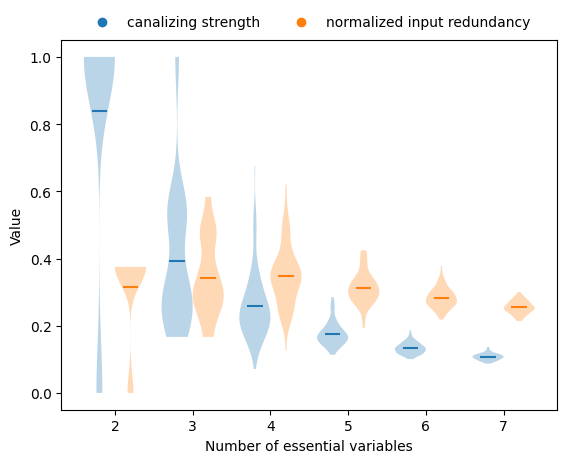

In [4]:
nsim = 100
ns = np.arange(2, 8)

canalizing_strengths = np.zeros((len(ns), nsim))
input_redundancies = np.zeros((len(ns), nsim))

for j in range(nsim):
    for i, n in enumerate(ns):
        f = boolforge.random_function(n)
        canalizing_strengths[i, j] = f.get_canalizing_strength()
        input_redundancies[i, j] = f.get_input_redundancy()

width = 0.4
fig, ax = plt.subplots()

ax.violinplot(
    canalizing_strengths.T,
    positions=ns - width / 2,
    widths=width,
    showmeans=True,
    showextrema=False,
)
ax.scatter([], [], color="C0", label="canalizing strength")

ax.violinplot(
    input_redundancies.T,
    positions=ns + width / 2,
    widths=width,
    showmeans=True,
    showextrema=False,
)
ax.scatter([], [], color="C1", label="normalized input redundancy")

ax.legend(
    loc="center",
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    ncol=2,
)
ax.set_xlabel("Number of essential variables")
ax.set_ylabel("Value")
plt.show()

Both measures decrease with increasing degree, but canalizing strength declines more sharply.

If we stratify this analysis by canalizing depth 
(exact canalizing depth using `EXACT_DEPTH=True` or minimal canalizing depth using the default `EXACT_DEPTH=False`),
we can confirm that functions with more conditionally canalizing variables tend to also have higher average collective canalization, 
irrespective of how it is measured.
In other words, the various measures of canalization are all highly correlated.

### Stratification by canalizing depth

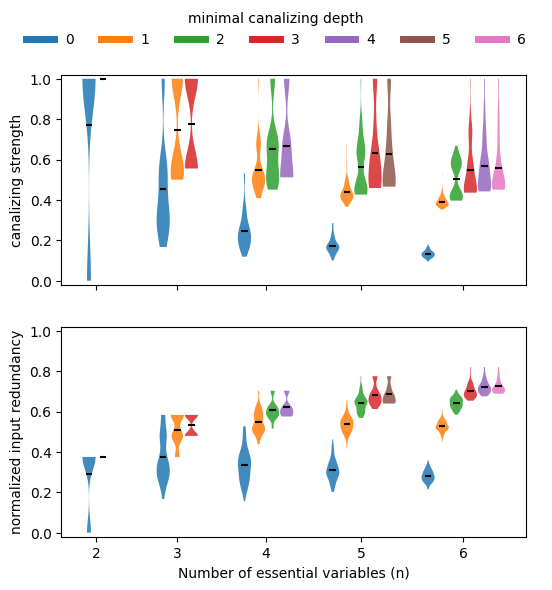

In [5]:
nsim = 100
EXACT_DEPTH = False
ns = np.arange(2, 7)

max_depth = max(ns)

canalizing_strengths = np.zeros((len(ns), max_depth + 1, nsim))
input_redundancies = np.zeros((len(ns), max_depth + 1, nsim))

for k in range(nsim):
    for i, n in enumerate(ns):
        for depth in np.append(np.arange(n - 1), n):
            f = boolforge.random_function(n, depth=depth, EXACT_DEPTH=EXACT_DEPTH)
            canalizing_strengths[i, depth, k] = f.get_canalizing_strength()
            input_redundancies[i, depth, k] = f.get_input_redundancy()

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

base_gap = 1.0
intra_gap = 0.3
width = 0.28

for ii, (data, label) in enumerate(
    zip(
        [canalizing_strengths, input_redundancies],
        ["canalizing strength", "normalized input redundancy"],
    )
):
    positions = []
    values = []
    colors = []
    group_centers = []

    current_x = 0.0
    for i, n in enumerate(ns):
        depths = np.append(np.arange(n - 1), n)
        offsets = np.linspace(
            -(len(depths) - 1) * intra_gap / 2,
            (len(depths) - 1) * intra_gap / 2,
            len(depths),
        )
        group_positions = current_x + offsets
        positions.extend(group_positions)
        group_centers.append(current_x)

        for d in depths:
            values.append(data[i, d, :])
            colors.append("C" + str(d))

        group_width = (len(depths) - 1) * intra_gap
        current_x += group_width / 2 + base_gap + width + intra_gap

    for pos, val, c in zip(positions, values, colors):
        vp = ax[ii].violinplot(val, positions=[pos], widths=width, showmeans=True, showextrema=False)
        for body in vp["bodies"]:
            body.set_facecolor(c)
            body.set_alpha(0.85)
        vp["cmeans"].set_color("k")

    ax[ii].set_ylabel(label)
    ax[ii].set_ylim([-0.02, 1.02])

ax[1].set_xlabel("Number of essential variables (n)")
ax[1].set_xticks(group_centers)
ax[1].set_xticklabels(ns)

depth_handles = [
    plt.Line2D([0], [0], color="C" + str(d), lw=5, label=str(d))
    for d in range(max_depth + 1)
]

fig.legend(
    handles=depth_handles,
    loc="upper center",
    ncol=7,
    frameon=False,
    title="exact canalizing depth" if EXACT_DEPTH else "minimal canalizing depth",
)
plt.show()

---
### Correlation between canalizing strength and input redundancy

We can generate all (non-degenerate) Boolean functions of a certain degree $n$ 
(only feasible up to $n=4$) and compare canalizing strength and input redundancy.

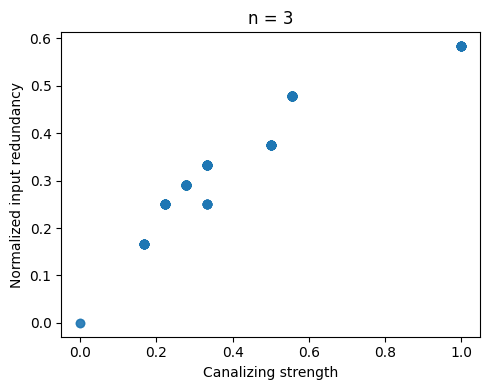

SignificanceResult(statistic=np.float64(0.9700304760700043), pvalue=np.float64(1.0759731607818433e-134))

In [6]:
n = 3
ALLOW_DEGENERATE_FUNCTIONS = False
degenerate = np.zeros(2 ** (2**n), dtype=bool)
strengths = np.zeros(2 ** (2**n))
redundancies = np.zeros(2 ** (2**n))

for i, fvec in enumerate(boolforge.get_left_side_of_truth_table(2**n)):
    bf = boolforge.BooleanFunction(fvec)
    strengths[i] = bf.get_canalizing_strength()
    redundancies[i] = bf.get_input_redundancy()
    if not ALLOW_DEGENERATE_FUNCTIONS:
        degenerate[i] = bf.is_degenerate()
        
if ALLOW_DEGENERATE_FUNCTIONS:
    which = np.ones(2 ** (2**n), dtype=bool)
else:
    which = ~degenerate
    

plt.figure(figsize=(5, 4))
plt.scatter(strengths[which], redundancies[which], alpha=0.7)
plt.xlabel("Canalizing strength")
plt.ylabel("Normalized input redundancy")
plt.title(f"n = {n}")
plt.tight_layout()
plt.show()

stats.spearmanr(strengths[which], redundancies[which])

Both measures are highly correlated but markedly not the same.
Some functions possess relatively high canalizing strength but low input redundancy, and vice versa.
It remains an open question what drives this behavior.

---
## 3. Correlation between canalization and bias

Basically all metrics used to assess the sensitivity of Boolean functions (canalization, absolute bias, average sensitivity) are correlated. 
For example, functions with higher absolute bias are more likely to be canalizing.

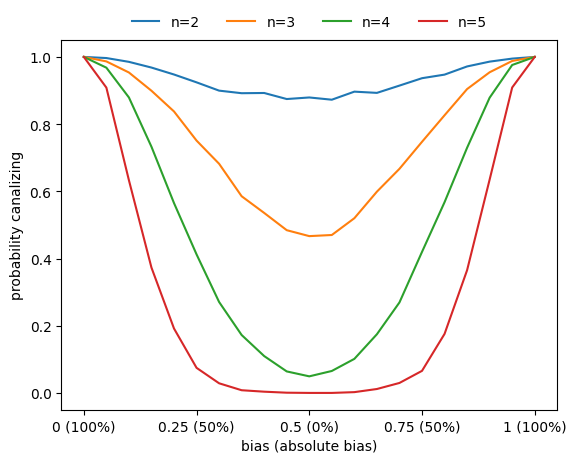

In [7]:
ns = np.arange(2, 6)
nsim = 3000
bias_values = np.linspace(0, 1, 21)

count_canalizing = np.zeros((len(ns), len(bias_values)), dtype=int)

for i, n in enumerate(ns):
    for _ in range(nsim):
        for j, bias in enumerate(bias_values):
            f = boolforge.random_function(n, bias=bias, ALLOW_DEGENERATE_FUNCTIONS=True)
            if f.is_canalizing():
                count_canalizing[i, j] += 1

fig, ax = plt.subplots()
for i, n in enumerate(ns):
    ax.plot(bias_values, count_canalizing[i] / nsim, label=f"n={n}")

xticks = [0, 0.25, 0.5, 0.75, 1]
ax.set_xticks(xticks)
ax.set_xticklabels([f"{p} ({round(200*abs(p-0.5))}%)" for p in xticks])
ax.set_xlabel("bias (absolute bias)")
ax.set_ylabel("probability canalizing")
ax.legend(
    loc="center",
    frameon=False,
    bbox_to_anchor=(0.5, 1.05),
    ncol=6,
)
plt.show()

### Degeneracy vs bias

Similarly, the probability that a function is degenerate (i.e., that it does not depend on all its variables) 
also increases as the absolute bias increases.

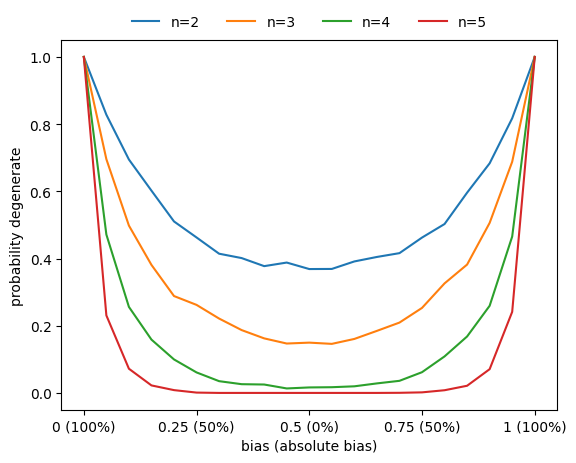

In [8]:
count_degenerate = np.zeros((len(ns), len(bias_values)), dtype=int)

for i, n in enumerate(ns):
    for _ in range(nsim):
        for j, bias in enumerate(bias_values):
            f = boolforge.random_function(n, bias=bias, ALLOW_DEGENERATE_FUNCTIONS=True)
            if f.is_degenerate():
                count_degenerate[i, j] += 1

fig, ax = plt.subplots()
for i, n in enumerate(ns):
    ax.plot(bias_values, count_degenerate[i] / nsim, label=f"n={n}")

ax.set_xticks(xticks)
ax.set_xticklabels([f"{p} ({round(200*abs(p-0.5))}%)" for p in xticks])
ax.set_xlabel("bias (absolute bias)")
ax.set_ylabel("probability degenerate")
ax.legend(
    loc="center",
    frameon=False,
    bbox_to_anchor=(0.5, 1.05),
    ncol=6,
)
plt.show()

---
## 4. Analyzing functions with specific canalizing layer structure

The average sensitivity of the Boolean functions governing the updates in a Boolean network, determines the stability of the network to perturbations. 
More generally, it determines the dynamical regime of the network (see Tutorial 8). 
The ability to generate canalizing functions with a specific canalizing layer structure enables us 
to investigate the link between layer structure and average sensitivity, as well as other properties, 
such as canalizing strength or effective degree.

For nested canalizing functions of a given degree $n$, there exists a bijection 
between their absolute bias and their canalizing layer structure (Kadelka et al., Physica D, 2017).
The function `boolforge.get_layer_structure_of_an_NCF_given_its_Hamming_weight(degree,hamming_weight)` implements this.
NCFs with the same layer structure have the same dynamical properties. 
That is, they have the same average sensitivity, canalizing strength and the same effective degree.
Iterating over all possible absolute biases (parametrized by the possible Hamming weights), 
we can thus generate all dynamically different types of n-input NCFs and investigate their average sensitivity, 
which we can compute exactly for relatively low degree.

In [9]:
n = 5
all_hamming = np.arange(1, 2 ** (n - 1), 2)
all_abs_bias = all_hamming / 2 ** (n - 1)

avg_sens = np.zeros(2 ** (n - 2))
can_strength = np.zeros_like(avg_sens)
eff_degree = np.zeros_like(avg_sens)
layer_structures = []

for i, w in enumerate(all_hamming):
    layer = boolforge.get_layer_structure_of_an_NCF_given_its_Hamming_weight(n, w)
    layer_structures.append(layer)
    f = boolforge.random_function(n, layer_structure=layer)
    avg_sens[i] = f.get_average_sensitivity(EXACT=True, NORMALIZED=False)
    can_strength[i] = f.get_canalizing_strength()
    eff_degree[i] = f.get_effective_degree()

df = pd.DataFrame(
    {
        "Hamming weight": all_hamming,
        "Absolute bias": all_abs_bias,
        "Layer structure": list(map(str, layer_structures)),
        "Number of layers": list(map(len, layer_structures)),
        "Average sensitivity": avg_sens,
        "Canalizing strength": np.round(can_strength, 4),
        "Effective degree": np.round(eff_degree, 4),
    }
)

print(df.to_string())

   Hamming weight  Absolute bias Layer structure  Number of layers  Average sensitivity  Canalizing strength  Effective degree
0               1         0.0625             [5]                 1               0.3125               1.0000            1.1250
1               3         0.1875          [3, 2]                 2               0.6875               0.7705            1.3984
2               5         0.3125       [2, 1, 2]                 3               0.9375               0.6369            1.5938
3               7         0.4375          [2, 3]                 2               1.0625               0.5993            1.5833
4               9         0.5625       [1, 1, 3]                 3               1.1875               0.5033            1.7266
5              11         0.6875    [1, 1, 1, 2]                 4               1.3125               0.4657            1.8021
6              13         0.8125       [1, 2, 2]                 3               1.3125               0.4657   

We notice that nested canalizing functions with higher absolute bias tend to be 
more sensitive to input changes and also less canalizing. 
However, the relationship between absolute bias and these other metrics is far from monotonic. 
Further, we notice that there is a perfect correlation between the average sensitivity of a nested canalizing function and its canalizing strength, 
and a near perfect correlation between average sensitivity and effective degree.

To investigate the non-monotonic behavior further, 
we can vary the degree and create line plots that reveal a clear pattern, as shown in Kadelka et al., Physica D, 2017.

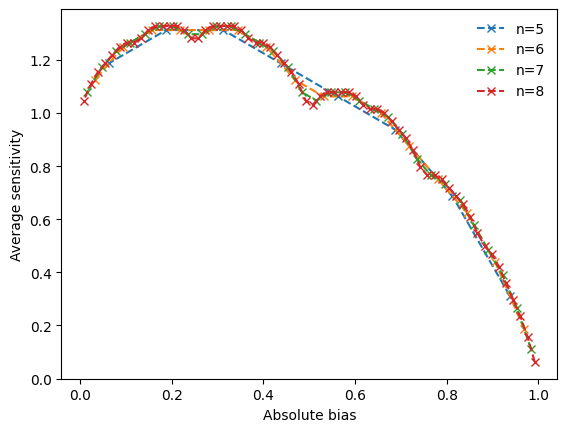

In [10]:
ns = np.arange(5, 9)
fig, ax = plt.subplots()

for n in ns:
    all_hamming = np.arange(1, 2 ** (n - 1), 2)
    all_abs_bias = 2 * np.abs(all_hamming/2**n - 0.5)
    avg_sens = np.zeros(2 ** (n - 2))

    for i, w in enumerate(all_hamming):
        layer = boolforge.get_layer_structure_of_an_NCF_given_its_Hamming_weight(n, w)
        f = boolforge.random_function(n, layer_structure=layer)
        avg_sens[i] = f.get_average_sensitivity(EXACT=True, NORMALIZED=False)

    ax.plot(all_abs_bias, avg_sens, "x--", label=f"n={n}")

ax.legend(frameon=False)
ax.set_xlabel("Absolute bias")
ax.set_ylabel("Average sensitivity")
plt.show()

---
## 5. Summary and outlook

This tutorial illustrated how ensembles of Boolean functions generated under
explicit constraints reveal systematic relationships between canalization,
bias, redundancy, and sensitivity.

The key findings include: 

1. Canalization is rare in random functions but common in biology.
2. Canalizing strength and input redundancy both decrease with degree.
3. Functions with high absolute bias are more likely to be highly canalizing.
4. For NCFs, layer structure is uniquely determined by bias.
5. Average sensitivity varies systematically with layer structure.

These relationships constrain the space of biologically plausible functions
and suggest evolutionary optimization for robustness.

We now move on to Boolean networks, where Boolean functions serve as node update
rules and give rise to collective dynamical behavior.